[![Supervision](https://media.roboflow.com/open-source/supervision/rf-supervision-banner.png?updatedAt=1678995927529)](https://github.com/roboflow/supervision)

# Supervision Quickstart

---

[![version](https://badge.fury.io/py/supervision.svg)](https://badge.fury.io/py/supervision)
[![downloads](https://img.shields.io/pypi/dm/supervision)](https://pypistats.org/packages/supervision)
[![license](https://img.shields.io/pypi/l/supervision)](https://github.com/roboflow/supervision/blob/main/LICENSE.md)
[![python-version](https://img.shields.io/pypi/pyversions/supervision)](https://badge.fury.io/py/supervision)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/supervision)

We write your reusable computer vision tools. Whether you need to load your dataset from your hard drive, draw detections on an image or video, or count how many detections are in a zone. You can count on us! 🤝

We hope that the resources in this notebook will help you get the most out of Supervision. Please browse the Supervision [Docs](https://roboflow.github.io/supervision/) for details, raise an [issue](https://github.com/roboflow/supervision/issues) on GitHub for support, and join our [discussions](https://github.com/roboflow/supervision/discussions) section for questions!

## Table of contents

- Before you start
- Install
- Detection API
    - Plug in your model
        - YOLO-NAS
        - YOLOv8
    - Annotate
        - `BoxAnnotator`, `LabelAnnotator`
        - `MaskAnnotator`
    - Filter
        - By index, index list and index slice
        - By `class_id`
        - By `confidence`
        - By advanced logical condition
- Video API
    - `VideoInfo`
    - `get_video_frames_generator`
    - `VideoSink`
- Dataset API
    - `DetectionDataset.from_yolo`
    - Visualize annotations
    - `split`
    - `DetectionDataset.as_pascal_voc`


## ⚡ Before you start

**NOTE:** In this notebook, we aim to show - among other things - how simple it is to integrate `supervision` with popular object detection and instance segmentation libraries and frameworks. GPU access is optional but will certainly make the ride smoother.

<br>

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [51]:
!nvidia-smi

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [52]:
import os

HOME = os.getcwd()
print(HOME)

**NOTE:** During our demo, we will need some example images.

In [53]:
!mkdir {HOME}/images

**NOTE:** Feel free to use your images. Just make sure to put them into `images` directory that we just created. ☝️

In [54]:
%cd {HOME}/images

!wget -q https://media.roboflow.com/notebooks/examples/dog.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-4.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-5.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-6.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-7.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-8.jpeg

Thu Jul 11 20:48:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0              32W /  70W |    473MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## ‍💻 Install

In [55]:
!pip install -q supervision

import supervision as sv

print(sv.__version__)

## 👁️ Detection API

- xyxy `(np.ndarray)`: An array of shape `(n, 4)` containing the bounding boxes coordinates in format `[x1, y1, x2, y2]`
- mask: `(Optional[np.ndarray])`: An array of shape `(n, W, H)` containing the segmentation masks.
- confidence `(Optional[np.ndarray])`: An array of shape `(n,)` containing the confidence scores of the detections.
- class_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the class ids of the detections.
- tracker_id `(Optional[np.ndarray])`: An array of shape `(n,)` containing the tracker ids of the detections.

### 🔌 Plug in your model

**NOTE:** In our example, we will focus only on integration with YOLO-NAS and YOLOv8. However, keep in mind that supervision allows seamless integration with many other models like SAM, Transformers, and YOLOv5. You can learn more from our [documentation](https://roboflow.github.io/supervision/detection/core/#detections).

In [96]:
import cv2

IMAGE_PATH = f"{HOME}/images/dog.jpeg"

image = cv2.imread(IMAGE_PATH)

### YOLO-NAS [📚](https://roboflow.github.io/supervision/detection/core/#supervision.detection.core.Detections.from_yolo_nas)

In [57]:
!pip install -q super-gradients

0.21.0


In [58]:
from super_gradients.training import models

model = models.get("yolo_nas_l", pretrained_weights="coco")
result = model.predict(image)
detections = sv.Detections.from_yolo_nas(result)

[2024-07-11 20:48:37] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-07-11 20:48:37] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
[2024-07-11 20:48:38] INFO - checkpoint_utils.py - Successfully loaded pretrained weights for architecture yolo_nas_l
[2024-07-11 20:48:38] INFO - pipelines.py - Fusing some of the model's layers. If this takes 

In [59]:
"detections", len(detections)

('detections', 7)

### Ultralytics [📚](https://roboflow.github.io/supervision/detection/core/#supervision.detection.core.Detections.from_ultralytics)

In [60]:
!pip install -q ultralytics

In [97]:
from ultralytics import YOLO

model = YOLO("yolov8m.pt")
result = model(image, verbose=False)[0]
detections = sv.Detections.from_ultralytics(result)

100%|██████████| 49.7M/49.7M [00:00<00:00, 363MB/s]


In [62]:
model = YOLO("yolov8m-seg.pt")
result = model(image, verbose=False)[0]
detections_segmentation = sv.Detections.from_ultralytics(result)

100%|██████████| 52.4M/52.4M [00:00<00:00, 69.6MB/s]


In [63]:
"detections", len(detections)

('detections', 4)

### 👩‍🎨 Annotate

### BoxAnnotator [📚](https://supervision.roboflow.com/latest/detection/annotators/#supervision.annotators.core.BoxAnnotator)

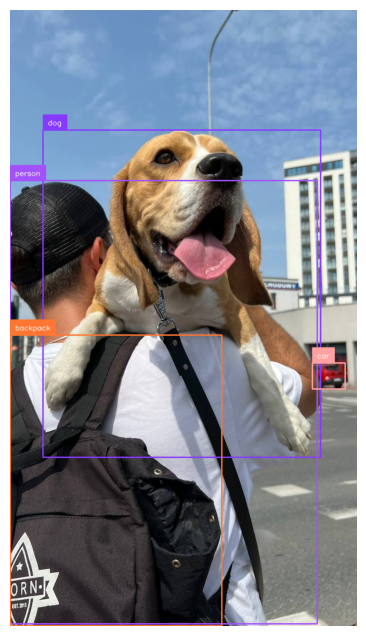

In [64]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

annotated_image = box_annotator.annotate(image.copy(), detections=detections)
annotated_image = label_annotator.annotate(annotated_image, detections=detections)

sv.plot_image(image=annotated_image, size=(8, 8))

**NOTE:** By default `sv.LabelAnnotator` use corresponding `class_id` as label, however, the labels can have arbitrary format.

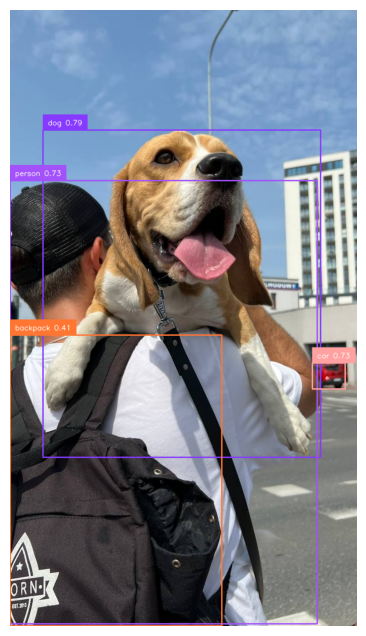

In [65]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

labels = [
    f"{model.model.names[class_id]} {confidence:.2f}"
    for class_id, confidence in zip(detections.class_id, detections.confidence)
]
annotated_image = box_annotator.annotate(
    image.copy(),
    detections=detections,
)
annotated_image = label_annotator.annotate(
    annotated_image, detections=detections, labels=labels
)

sv.plot_image(image=annotated_image, size=(8, 8))

### MaskAnnotator [📚](https://roboflow.github.io/supervision/detection/annotate/#maskannotator)

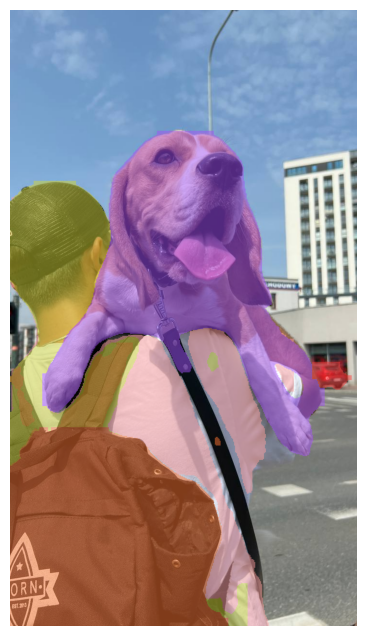

In [66]:
mask_annotator = sv.MaskAnnotator(color_lookup=sv.ColorLookup.INDEX)

annotated_image = mask_annotator.annotate(
    image.copy(), detections=detections_segmentation
)

sv.plot_image(image=annotated_image, size=(8, 8))

## 🗑 Filter [📚](https://roboflow.github.io/supervision/quickstart/detections/)

### By index, index list and index slice

**NOTE:** `sv.Detections` filter API allows you to access detections by index, index list or index slice

In [67]:
detections_index = detections[0]
detections_index_list = detections[[0, 1, 3]]
detections_index_slice = detections[:2]

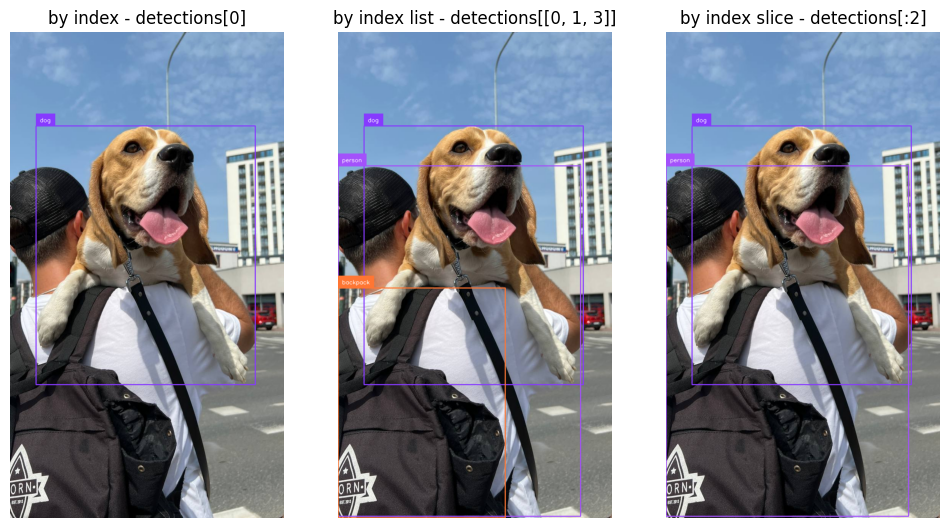

In [68]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

images = []
for d in [detections_index, detections_index_list, detections_index_slice]:
    annotated_image = box_annotator.annotate(image.copy(), detections=d)
    annotated_image = label_annotator.annotate(annotated_image, detections=d)
    images.append(annotated_image)
titles = [
    "by index - detections[0]",
    "by index list - detections[[0, 1, 3]]",
    "by index slice - detections[:2]",
]

sv.plot_images_grid(images=images, titles=titles, grid_size=(1, 3))

### By class_id

**NOTE:** Let's use `sv.Detections` filter API to display only objects with `class_id == 0`

In [69]:
detections_filtered = detections[detections.class_id == 0]

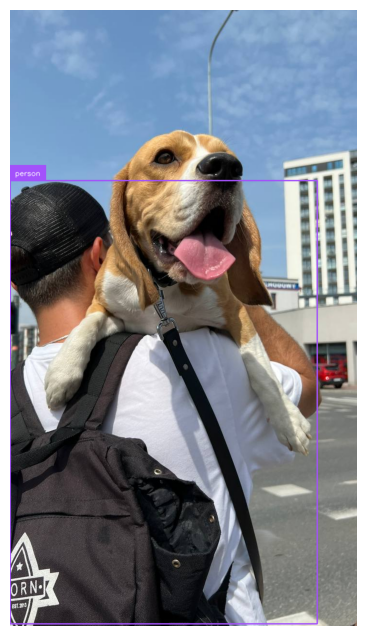

In [70]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
annotated_image = box_annotator.annotate(image.copy(), detections=detections_filtered)
annotated_image = label_annotator.annotate(
    annotated_image, detections=detections_filtered
)
sv.plot_image(image=annotated_image, size=(8, 8))

### By confidence

**NOTE:** Let's use `sv.Detections` filter API to display only objects with `confidence > 0.7`

In [100]:
detections_filtered = detections[detections.confidence > 0.7]

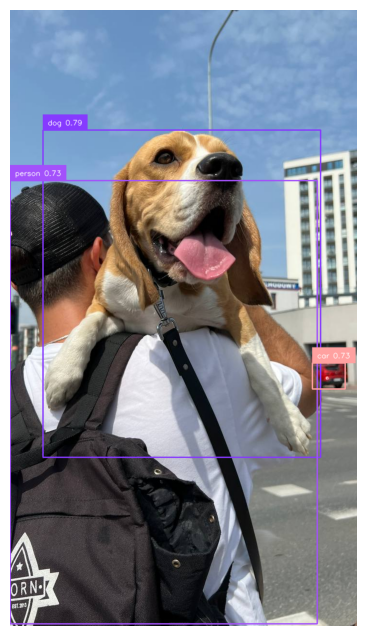

In [101]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
labels = []
for class_id, confidence in zip(
    detections_filtered.class_id, detections_filtered.confidence
):
    labels.append(f"{model.model.names[class_id]} {confidence:.2f}")
annotated_image = box_annotator.annotate(
    image.copy(),
    detections=detections_filtered,
)
annotated_image = label_annotator.annotate(
    annotated_image, detections=detections_filtered, labels=labels
)
sv.plot_image(image=annotated_image, size=(8, 8))

### By advanced logical condition

**NOTE:** Let's use `sv.Detections` filter API allows you to build advanced logical conditions. Let's select only detections with `class_id != 0` and `confidence > 0.7`.

In [103]:
detections_filtered = detections[
    (detections.class_id != 0) & (detections.confidence > 0.7)
]

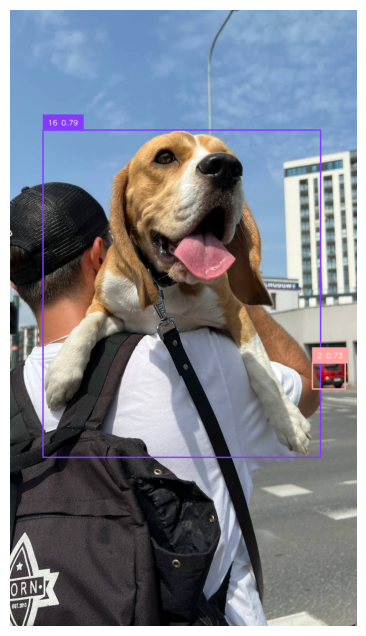

In [104]:
box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
labels = [
    f"{class_id} {confidence:.2f}"
    for class_id, confidence in zip(
        detections_filtered.class_id, detections_filtered.confidence
    )
]
annotated_image = box_annotator.annotate(
    image.copy(),
    detections=detections_filtered,
)
annotated_image = label_annotator.annotate(
    annotated_image, detections=detections_filtered, labels=labels
)

sv.plot_image(image=annotated_image, size=(8, 8))

## 🎬 Video API

**NOTE:** `supervision` offers a lot of utils to make working with videos easier. Let's take a look at some of them.

**NOTE:** During our demo, we will need some example videos.

In [75]:
!pip install -q supervision[assets]

In [76]:
!mkdir {HOME}/videos

**NOTE:** Feel free to use your videos. Just make sure to put them into `videos` directory that we just created. ☝️

In [77]:
%cd {HOME}/videos

In [78]:
from supervision.assets import VideoAssets, download_assets

download_assets(VideoAssets.VEHICLES)
VIDEO_PATH = VideoAssets.VEHICLES.value

/content/datasets/images/videos



  0%|          | 0/35345757 [00:00<?, ?it/s]

### VideoInfo [📚](https://roboflow.github.io/supervision/utils/video/#videoinfo)

**NOTE:** `VideoInfo` allows us to easily retrieve information about video files, such as resolution, FPS and total number of frames.

In [79]:
sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=538)

### get_video_frames_generator [📚](https://roboflow.github.io/supervision/utils/video/#get_video_frames_generator)

In [80]:
frame_generator = sv.get_video_frames_generator(source_path=VIDEO_PATH)

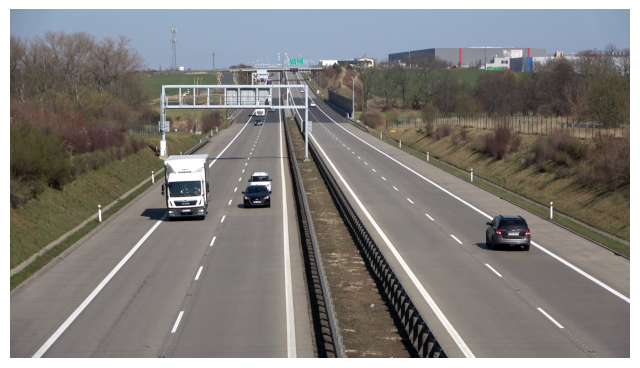

In [81]:
frame = next(iter(frame_generator))
sv.plot_image(image=frame, size=(8, 8))

### VideoSink [📚](https://roboflow.github.io/supervision/utils/video/#videosink)

In [82]:
RESULT_VIDEO_PATH = f"{HOME}/videos/vehicle-counting-result.mp4"

**NOTE:** Note that this time we have given a custom value for the `stride` parameter equal to `2`. As a result, `get_video_frames_generator` will return us every second video frame.

In [83]:
video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)

with sv.VideoSink(target_path=RESULT_VIDEO_PATH, video_info=video_info) as sink:
    for frame in sv.get_video_frames_generator(source_path=VIDEO_PATH, stride=2):
        sink.write_frame(frame=frame)

**NOTE:** If we once again use `VideoInfo` we will notice that the final video has 2 times fewer frames.

In [84]:
sv.VideoInfo.from_video_path(video_path=RESULT_VIDEO_PATH)

VideoInfo(width=3840, height=2160, fps=25, total_frames=269)

## 🖼️ Dataset API

**NOTE:** In order to demonstrate the capabilities of the Dataset API, we need a dataset. Let's download one from [Roboflow Universe](https://universe.roboflow.com/). To do this we first need to install the `roboflow` pip package.

In [85]:
!pip install -q roboflow

In [86]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets

import roboflow
from roboflow import Roboflow

roboflow.login()

rf = Roboflow()

project = rf.workspace("roboflow-jvuqo").project("fashion-assistant-segmentation")
dataset = project.version(5).download("yolov8")

/content/datasets/images/datasets
visit https://app.roboflow.com/auth-cli to get your authentication token.
Paste the authentication token here: ··········
loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.54, to fix: `pip install ultralytics==8.0.196`


Extracting Dataset Version Zip to fashion-assistant-segmentation-5 in yolov8::  15%|█▍        | 187/1254 [00:00<00:00, 1860.52it/s]

Extracting Dataset Version Zip to fashion-assistant-segmentation-5 in yolov8::  43%|████▎     | 538/1254 [00:00<00:00, 1529.93it/s]

### DetectionDataset.from_yolo [📚](https://roboflow.github.io/supervision/dataset/core/#supervision.dataset.core.DetectionDataset.from_yolo)

**NOTE:** Currently Dataset API always loads loads images from hard drive. In the future, we plan to add lazy loading.

In [87]:
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset.location}/train/images",
    annotations_directory_path=f"{dataset.location}/train/labels",
    data_yaml_path=f"{dataset.location}/data.yaml",
)

Extracting Dataset Version Zip to fashion-assistant-segmentation-5 in yolov8:: 100%|██████████| 1254/1254 [00:00<00:00, 2505.30it/s]


In [88]:
len(ds)

573

In [89]:
ds.classes

['baseball cap',
 'hoodie',
 'jacket',
 'pants',
 'shirt',
 'shorts',
 'sneaker',
 'sunglasses',
 'sweatshirt',
 't-shirt']

### 🏷️ Visualize annotations

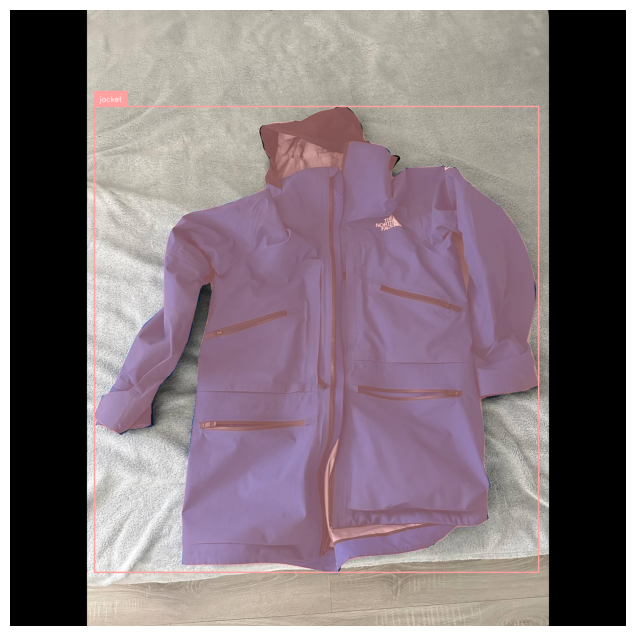

In [90]:
IMAGE_NAME = list(ds.images.keys())[0]

image = ds.images[IMAGE_NAME]
annotations = ds.annotations[IMAGE_NAME]

box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()
mask_annotator = sv.MaskAnnotator()

labels = [f"{ds.classes[class_id]}" for class_id in annotations.class_id]

annotated_image = mask_annotator.annotate(image.copy(), detections=annotations)
annotated_image = box_annotator.annotate(annotated_image, detections=annotations)
annotated_image = label_annotator.annotate(
    annotated_image, detections=annotations, labels=labels
)

sv.plot_image(image=annotated_image, size=(8, 8))

### split [📚](https://roboflow.github.io/supervision/dataset/core/#supervision.dataset.core.DetectionDataset.split)

In [91]:
ds_train, ds_test = ds.split(split_ratio=0.8)

In [92]:
"ds_train", len(ds_train), "ds_test", len(ds_test)

('ds_train', 458, 'ds_test', 115)

### DetectionDataset.as_pascal_voc [📚](https://roboflow.github.io/supervision/dataset/core/#supervision.dataset.core.DetectionDataset.as_pascal_voc)

In [ ]:
ds_train.as_pascal_voc(
    images_directory_path=f"{HOME}/datasets/result/images",
    annotations_directory_path=f"{HOME}/datasets/result/labels",
)

## 🏆 Congratulations

### Learning Resources

- [Documentation](https://roboflow.github.io/supervision/)
- [GitHub](https://github.com/roboflow/supervision)
- [YouTube Supervision Playlist](https://www.youtube.com/playlist?list=PLZCA39VpuaZaoGIohe9aXVMm24MRvfu1E)